# Importing packages

In [1]:
from utils.plotting_functions import dual_heat_map
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance

c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math 
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV,LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances

import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 10),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


# Importing dataset after EDA

In [6]:
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_domain_knowledge.csv.zip")
df

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,...,BackRoll_Acc,Roll_Acc,UA_Z_LR_Vel,UA_Z_LL_Vel,UA_Z_TR_Vel,UA_Z_TL_Vel,UA_Z_LR_Pos,UA_Z_LL_Pos,UA_Z_TR_Pos,UA_Z_TL_Pos
0,0.000414,0.000265,0.000098,-0.000025,0.000003,-0.000055,0.000002,-0.000004,0.000047,0.000003,...,-0.000005,0.000051,-1.620000e-07,0.000005,3.240000e-07,-2.160000e-07,1.458000e-08,5.832000e-07,3.207600e-08,-2.332800e-08
1,0.000443,0.000308,0.000110,-0.000030,0.000003,-0.000054,0.000004,0.000001,0.000050,0.000003,...,-0.000005,0.000049,4.320000e-07,0.000006,2.700000e-07,-2.160000e-07,8.164800e-08,6.211080e-07,2.624400e-08,-2.332800e-08
2,0.000471,0.000350,0.000123,-0.000035,0.000004,-0.000053,0.000006,0.000007,0.000053,0.000002,...,-0.000004,0.000046,1.080000e-06,0.000006,2.160000e-07,-2.160000e-07,1.516320e-07,6.619320e-07,2.332800e-08,-2.332800e-08
3,0.000500,0.000393,0.000135,-0.000041,0.000004,-0.000051,0.000007,0.000013,0.000057,0.000002,...,-0.000004,0.000044,1.728000e-06,0.000006,2.160000e-07,-2.160000e-07,2.157840e-07,6.998400e-07,2.332800e-08,-2.332800e-08
4,0.000529,0.000435,0.000147,-0.000046,0.000004,-0.000050,0.000009,0.000019,0.000060,0.000002,...,-0.000004,0.000041,2.268000e-06,0.000007,2.160000e-07,-2.160000e-07,2.741040e-07,7.319160e-07,2.332800e-08,-2.332800e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.050300,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,...,-0.030472,-0.030472,4.267620e-04,0.000106,2.842236e-03,-1.839240e-04,4.115642e-05,7.158780e-06,2.960615e-04,-3.872448e-06
68151,-0.113222,-0.225703,0.140285,0.042200,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,...,-0.025568,-0.025568,3.353940e-04,0.000027,2.640384e-03,1.122120e-04,3.083962e-05,-1.143072e-06,2.780989e-04,3.023017e-05
68152,-0.114092,-0.220937,0.148758,0.034700,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,...,-0.021250,-0.021250,2.357100e-04,-0.000048,2.509596e-03,4.476060e-04,1.988712e-05,-9.509076e-06,2.590691e-04,6.650230e-05
68153,-0.114961,-0.216170,0.157232,0.027200,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,...,-0.016935,-0.016935,1.325700e-04,-0.000128,2.287980e-03,7.839180e-04,7.158780e-06,-6.908004e-06,1.235509e-04,4.233157e-05


In [7]:
df_aux = df.copy()

## Reference model

In [8]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=True) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [9]:
# y = df_aux['Vert_irreg_right_rail']
# X = df_aux.drop(['Vert_irreg_right_rail'],axis=1)

y = df_aux['Irr_Z_RR']
X = df_aux.drop(['Irr_Z_RR'],axis=1)

X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

# Time domain features

Time domain features are created using a rolling window, as shown below. A specific metric is calculated for each window, generating a new column. This window then moves downward until the end of the column. The size of the window is a hyperparameter that was optimized through trial and error.

<img src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/conv1d.gif?raw=true" width="500">

In [10]:
from IPython.display import Image
Image(url='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif') 

In [11]:
def time_features(x, window):
    #nan = [np.nan, np.nan, np.nan, np.nan, np.nan, 
    #       np.nan, np.nan, np.nan, np.nan, np.nan,
    #       np.nan, np.nan, np.nan]
    
    nan = [np.nan]*9

    N = len(x.index)
    if N != window:
        return nan

    x = x.to_numpy()
    
    try:
        x_abs = abs(x)
        p1 = x.mean()
        p2 = x.std()
        p3 = (np.sqrt(x_abs)).mean()
        p4 = p3*p3
        p5 = np.sqrt((x*x).mean())
        p6 = max(x_abs)
        p7 = sp.stats.skew(x)
        p8 = sp.stats.kurtosis(x)
        #p9 = p5/((np.sum(x_abs)/len(x))**2) # clearance_factor
        #p10 = p5/p4 # crest_factor
        #p11 = p5/p1 # impulse factor
        #p12 = p4/p1 # shape_factor
        p13 = x.max() - x.min() #peak_to_peak

        #return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13]
        return [p1, p2, p3, p4, p5, p6, p7, p8,p13]
    
    except ZeroDivisionError:
        return nan

In [17]:
# def time_feature_creation(window, df, columns):
    
#     df_rolling = df[columns].rolling(window=window)
    
#     for c in tqdm(columns):
#         colnames = ["{}_mean_{} S".format(c,str(window)),
#                     "{}_std_{} S".format(c,str(window)), 
#                     "{}_RMA_{} S".format(c,str(window)),
#                     "{}_MA_{} S".format(c,str(window)), 
#                     "{}_RMS_{} S".format(c,str(window)),
#                     "{}_max_abs_{} S".format(c,str(window)), 
#                     "{}_skew_{} S".format(c,str(window)),
#                     "{}_kurt_{} S".format(c,str(window)),
#                     #"{}_p9_{}samples".format(c,str(window)),
#                     #"{}_p10_{}samples".format(c,str(window)),
#                     #"{}_p11_{}samples".format(c,str(window)),
#                     #"{}_p12_{}samples".format(c,str(window)),
#                     "{}_peak_to_peak_{} S".format(c,str(window))
#                     ]
#         df[colnames] = pd.DataFrame([time_features(x[c], window) for x in df_rolling], columns=colnames, index=df.index)


def time_feature_creation(window, df, columns):

    df_rolling = df[columns].rolling(window=window)

    for c in tqdm(columns):
        colnames = ["{}_mean".format(c),
                    "{}_std".format(c),
                    "{}_RMA".format(c),
                    "{}_MA".format(c),
                    "{}_RMS".format(c),
                    "{}_max_abs".format(c),
                    "{}_skew".format(c),
                    "{}_kurt".format(c),
                    #"{}_p9_{}samples".format(c,str(window)),
                    #"{}_p10_{}samples".format(c,str(window)),
                    #"{}_p11_{}samples".format(c,str(window)),
                    #"{}_p12_{}samples".format(c,str(window)),
                    "{}_peak_to_peak".format(c)
                    ]
        df[colnames] = pd.DataFrame([time_features(x[c], window)
                                    for x in df_rolling], columns=colnames, index=df.index)


In [18]:
janelas = [55] 
columns = X.columns
columns

Index(['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR', 'TA_X', 'TA_Y', 'TA_Z',
       'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL', 'Acc_max', 'SuspTravel_L',
       'SuspTravel_R', 'SuspTravel', 'Pitch_Acc_R', 'Pitch_Acc_L', 'Pitch_Acc',
       'Pitch_Susp_R', 'Pitch_Susp_L', 'Pitch_Susp', 'FrontBounce_Susp',
       'BackBounce_Susp', 'Bounce_Susp', 'FrontBounce_Acc', 'BackBounce_Acc',
       'Bounce_Acc', 'FrontRoll_Susp', 'BackRoll_Susp', 'Roll_Susp',
       'FrontRoll_Acc', 'BackRoll_Acc', 'Roll_Acc', 'UA_Z_LR_Vel',
       'UA_Z_LL_Vel', 'UA_Z_TR_Vel', 'UA_Z_TL_Vel', 'UA_Z_LR_Pos',
       'UA_Z_LL_Pos', 'UA_Z_TR_Pos', 'UA_Z_TL_Pos'],
      dtype='object')

In [19]:
import time
from tqdm import tqdm
start_time = time.time()

for i in janelas:
    time_feature_creation(i, X, columns)
    print('{}s | {} minutes'.format(str(i), str((time.time() - start_time)/60)))

 27%|██▋       | 11/41 [04:17<11:35, 23.20s/it]C:\Users\arthu\AppData\Local\Temp\ipykernel_35148\2229843430.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colnames] = pd.DataFrame([time_features(x[c], window)
C:\Users\arthu\AppData\Local\Temp\ipykernel_35148\2229843430.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colnames] = pd.DataFrame([time_features(x[c], window)
C:\Users\arthu\AppData\Local\Temp\ipykernel_35148\2229843430.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

55s | 15.917740015188853 minutes


In [20]:
X_windowed = X.dropna(axis=0)
X_windowed

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,...,UA_Z_TR_Pos_peak_to_peak,UA_Z_TL_Pos_mean,UA_Z_TL_Pos_std,UA_Z_TL_Pos_RMA,UA_Z_TL_Pos_MA,UA_Z_TL_Pos_RMS,UA_Z_TL_Pos_max_abs,UA_Z_TL_Pos_skew,UA_Z_TL_Pos_kurt,UA_Z_TL_Pos_peak_to_peak
54,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000645,-0.000749,-0.001817,-0.002807,-0.000168,...,0.000378,0.000012,0.000054,0.001538,0.000002,0.000055,0.000328,4.646116,21.684439,0.000341
55,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000512,-0.000749,-0.001812,-0.003314,-0.000187,...,0.000378,0.000012,0.000054,0.001559,0.000002,0.000055,0.000328,4.646156,21.685709,0.000341
56,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000343,-0.000727,-0.001605,-0.003761,-0.000188,...,0.000378,0.000012,0.000054,0.001578,0.000002,0.000055,0.000328,4.646214,21.686920,0.000341
57,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000089,-0.000650,-0.000912,-0.004059,-0.000145,...,0.000378,0.000012,0.000054,0.001593,0.000003,0.000055,0.000328,4.646277,21.687921,0.000341
58,-0.037300,0.030900,0.025100,-0.0257,-0.000202,0.000166,-0.000574,-0.000219,-0.004359,-0.000103,...,0.000378,0.000012,0.000054,0.001604,0.000003,0.000055,0.000328,4.646327,21.688590,0.000341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.0503,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,...,0.002639,0.000086,0.000243,0.013313,0.000177,0.000258,0.000857,-1.005578,2.580910,0.001392
68151,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,...,0.002639,0.000080,0.000239,0.013049,0.000170,0.000252,0.000857,-1.010211,2.762400,0.001392
68152,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,...,0.002639,0.000073,0.000234,0.012821,0.000164,0.000245,0.000857,-1.049988,3.035751,0.001392
68153,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,...,0.002639,0.000066,0.000229,0.012557,0.000158,0.000238,0.000857,-1.105812,3.355952,0.001392


In [21]:
# y = df_aux['Vert_irreg_right_rail']
# y2 = y[X_windowed.index]

y = df_aux['Irr_Z_RR']
y2 = y[X_windowed.index]

df = pd.concat([X_windowed,y2],axis=1)
df

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,...,UA_Z_TL_Pos_mean,UA_Z_TL_Pos_std,UA_Z_TL_Pos_RMA,UA_Z_TL_Pos_MA,UA_Z_TL_Pos_RMS,UA_Z_TL_Pos_max_abs,UA_Z_TL_Pos_skew,UA_Z_TL_Pos_kurt,UA_Z_TL_Pos_peak_to_peak,Irr_Z_RR
54,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000645,-0.000749,-0.001817,-0.002807,-0.000168,...,0.000012,0.000054,0.001538,0.000002,0.000055,0.000328,4.646116,21.684439,0.000341,-0.0712
55,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000512,-0.000749,-0.001812,-0.003314,-0.000187,...,0.000012,0.000054,0.001559,0.000002,0.000055,0.000328,4.646156,21.685709,0.000341,-0.0753
56,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000343,-0.000727,-0.001605,-0.003761,-0.000188,...,0.000012,0.000054,0.001578,0.000002,0.000055,0.000328,4.646214,21.686920,0.000341,-0.0791
57,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000089,-0.000650,-0.000912,-0.004059,-0.000145,...,0.000012,0.000054,0.001593,0.000003,0.000055,0.000328,4.646277,21.687921,0.000341,-0.0827
58,-0.037300,0.030900,0.025100,-0.0257,-0.000202,0.000166,-0.000574,-0.000219,-0.004359,-0.000103,...,0.000012,0.000054,0.001604,0.000003,0.000055,0.000328,4.646327,21.688590,0.000341,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.0503,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,...,0.000086,0.000243,0.013313,0.000177,0.000258,0.000857,-1.005578,2.580910,0.001392,0.0486
68151,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,...,0.000080,0.000239,0.013049,0.000170,0.000252,0.000857,-1.010211,2.762400,0.001392,0.0511
68152,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,...,0.000073,0.000234,0.012821,0.000164,0.000245,0.000857,-1.049988,3.035751,0.001392,0.0535
68153,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,...,0.000066,0.000229,0.012557,0.000158,0.000238,0.000857,-1.105812,3.355952,0.001392,0.0558


All models for determining feature importance
[Lasso(random_state=0), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)]

Obtaining R2 score for all 6 models


100%|██████████| 6/6 [18:33<00:00, 185.61s/it]
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


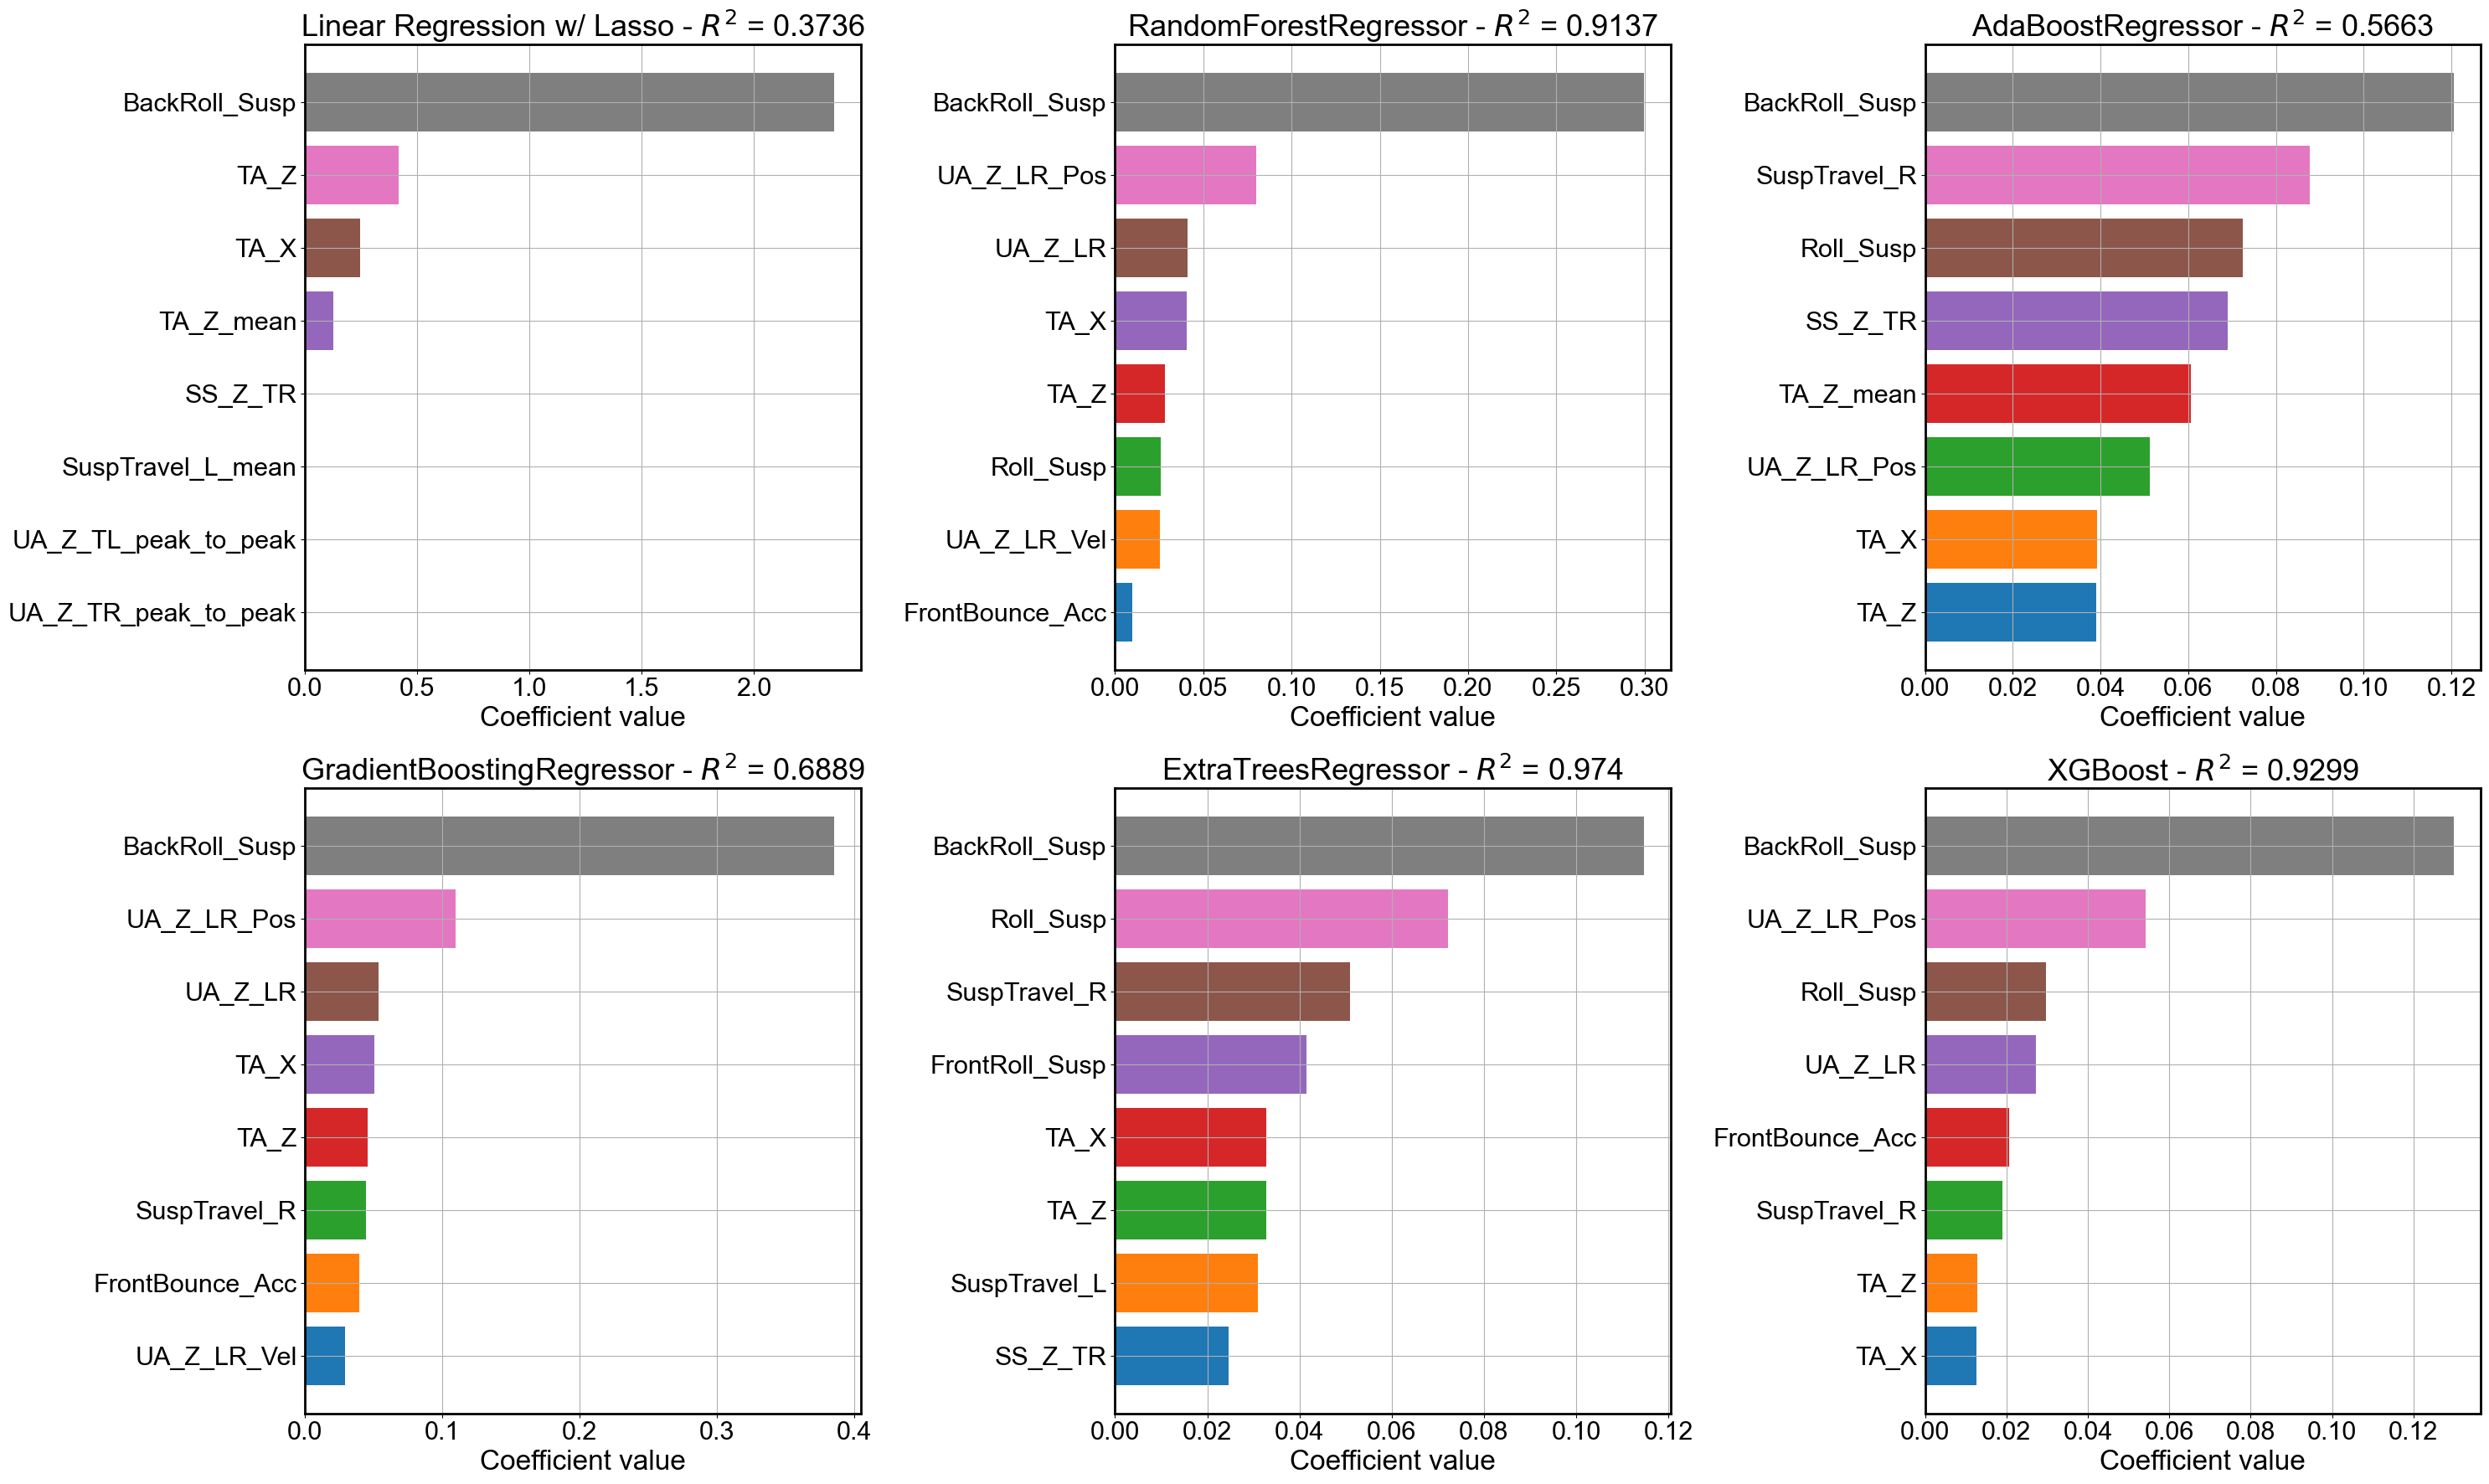

In [22]:
X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X_windowed,y2)

multi_select = multivariate_importance(X_scaled_train,X_scaled_test,y_train,y_test)
multi_select.plot(relative=False)

## Reduced dataset

In [29]:
from sklearn.feature_selection import SelectFromModel

mdl = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=0)
mdl.fit(X_scaled_train, y_train)

selector = SelectFromModel(estimator=mdl, threshold='1.1*mean')
selector.fit(X_scaled_train,y_train)

#The threshold value to use for feature selection. Features whose importance is greater or equal are kept while the others are discarded. 
# If “median” (resp. “mean”), then the threshold value is the median (resp. the mean) of the feature importances. 

SelectFromModel(estimator=ExtraTreesRegressor(n_jobs=-1, random_state=0),
                threshold='1.1*mean')

In [30]:
#print('Features selected by SelectFromModel:',selector.get_support())

In [31]:
selected_feat= X_scaled_train.columns[(selector.get_support())]
print(len(selected_feat))
print(selected_feat)

30
Index(['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR', 'TA_X', 'TA_Z', 'UA_Z_LR',
       'SuspTravel_L', 'SuspTravel_R', 'Pitch_Acc', 'FrontBounce_Acc',
       'FrontRoll_Susp', 'BackRoll_Susp', 'Roll_Susp', 'UA_Z_LR_Vel',
       'UA_Z_LR_Pos', 'SS_Z_TR_mean', 'SS_Z_LL_skew', 'SS_Z_TL_std',
       'SS_Z_LR_std', 'TA_X_mean', 'TA_X_RMA', 'TA_X_MA', 'TA_X_RMS',
       'TA_Z_mean', 'SuspTravel_mean', 'SuspTravel_skew', 'Pitch_Susp_L_mean',
       'Bounce_Susp_mean', 'FrontRoll_Susp_skew'],
      dtype='object')


In [32]:
X_train_2 = X_scaled_train[selected_feat]
X_test_2 = X_scaled_test[selected_feat]
X_test_2

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_mean,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew
42389,0.737243,-0.689163,0.911754,-1.106249,0.879843,0.275543,0.115474,0.680958,-0.897344,-0.012439,...,-0.308557,0.379312,0.283056,0.008873,0.306261,-1.144990,-0.526197,-2.136929,-2.120926,-0.442295
3225,0.934502,-0.953619,0.300003,-0.218240,0.139521,0.469321,-0.215454,-0.691708,0.797078,-0.277125,...,0.807023,0.238488,0.136528,0.135370,1.988957,0.576304,-0.252465,-0.861428,0.382449,-1.536658
57748,1.122369,-0.727549,-1.036674,0.969169,-0.913636,-0.557712,-0.198006,-0.862782,0.946660,0.400258,...,1.004661,0.790065,0.733635,0.778376,1.438482,1.141914,-0.883245,0.055961,0.339193,0.510795
42673,0.327909,0.123024,1.321458,-1.401586,-1.313845,0.538985,0.146479,1.005566,-1.131982,-0.390135,...,1.009818,0.121486,0.017876,0.144251,0.834292,-0.838621,-1.014255,-1.310552,-0.122889,1.092325
30295,-0.363931,0.664855,0.341504,-0.135917,-1.647333,-0.409228,0.243453,0.598156,-0.236751,0.138533,...,0.209663,1.610410,1.736894,1.025328,0.378880,1.197892,-1.347849,0.766650,-0.124296,-0.954054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5696,1.103117,-0.456206,-0.659949,0.170620,0.046962,-0.041315,-0.267161,-0.564303,0.931332,-0.443793,...,2.500834,2.191106,2.530347,3.390366,2.184709,-0.363655,1.043999,-0.092277,-0.045044,1.401938
56194,0.507372,-0.510054,-0.540539,0.534307,-1.201393,1.949248,-0.002784,-0.469694,0.456992,0.454120,...,0.474800,1.141320,1.146345,0.595633,0.639872,-0.463196,0.158701,-0.165121,-0.366871,2.109611
31831,0.151252,0.226634,-0.197510,0.289677,-1.310262,0.055929,0.165553,-0.197912,0.211685,-0.138789,...,0.464940,0.729134,0.664615,0.856998,1.006437,1.382367,-0.845989,0.271875,1.153242,0.367669
40300,1.494615,-1.621952,-1.455584,0.286785,-0.164139,1.356802,0.070960,-1.224345,1.243047,-0.055199,...,1.096215,-0.412058,-0.487668,0.481911,0.109020,-2.998091,0.269130,-2.732092,-3.379301,0.802379


In [33]:
#df_feature_engineered = pd.concat([df[selected_feat],df['Vert_irreg_right_rail']],axis=1)
df_feature_engineered = pd.concat([df[selected_feat],df['Irr_Z_RR']],axis=1)
df_feature_engineered

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew,Irr_Z_RR
54,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000749,-0.001817,0.030900,-0.034100,-0.000459,...,0.008054,0.000065,0.000457,-0.000293,0.004538,-1.143003,0.000911,0.001606,0.941525,-0.0712
55,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000749,-0.001812,0.031600,-0.035600,-0.000542,...,0.008238,0.000068,0.000457,-0.000307,0.003883,-1.156428,0.000941,0.001485,0.893110,-0.0753
56,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000727,-0.001605,0.032000,-0.036700,-0.000613,...,0.008436,0.000071,0.000458,-0.000320,0.003208,-1.139831,0.000970,0.001362,0.843661,-0.0791
57,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000650,-0.000912,0.031400,-0.037000,-0.000654,...,0.008647,0.000075,0.000459,-0.000332,0.002527,-1.100159,0.000993,0.001242,0.787577,-0.0827
58,-0.037300,0.030900,0.025100,-0.0257,-0.000202,-0.000574,-0.000219,0.030900,-0.037300,-0.000695,...,0.008870,0.000079,0.000459,-0.000342,0.001840,-1.048016,0.001013,0.001125,0.728316,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.0503,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285,0.0486
68151,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629,0.0511
68152,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025,0.0535
68153,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.000559,0.001721,-0.216170,-0.114961,-0.003272,...,0.053190,0.002829,0.004170,-0.008807,-0.639543,-0.864403,-0.063821,-0.135586,-0.816822,0.0558


All models for determining feature importance
[Lasso(random_state=0), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)]

Obtaining R2 score for all 6 models


100%|██████████| 6/6 [01:23<00:00, 13.85s/it]
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


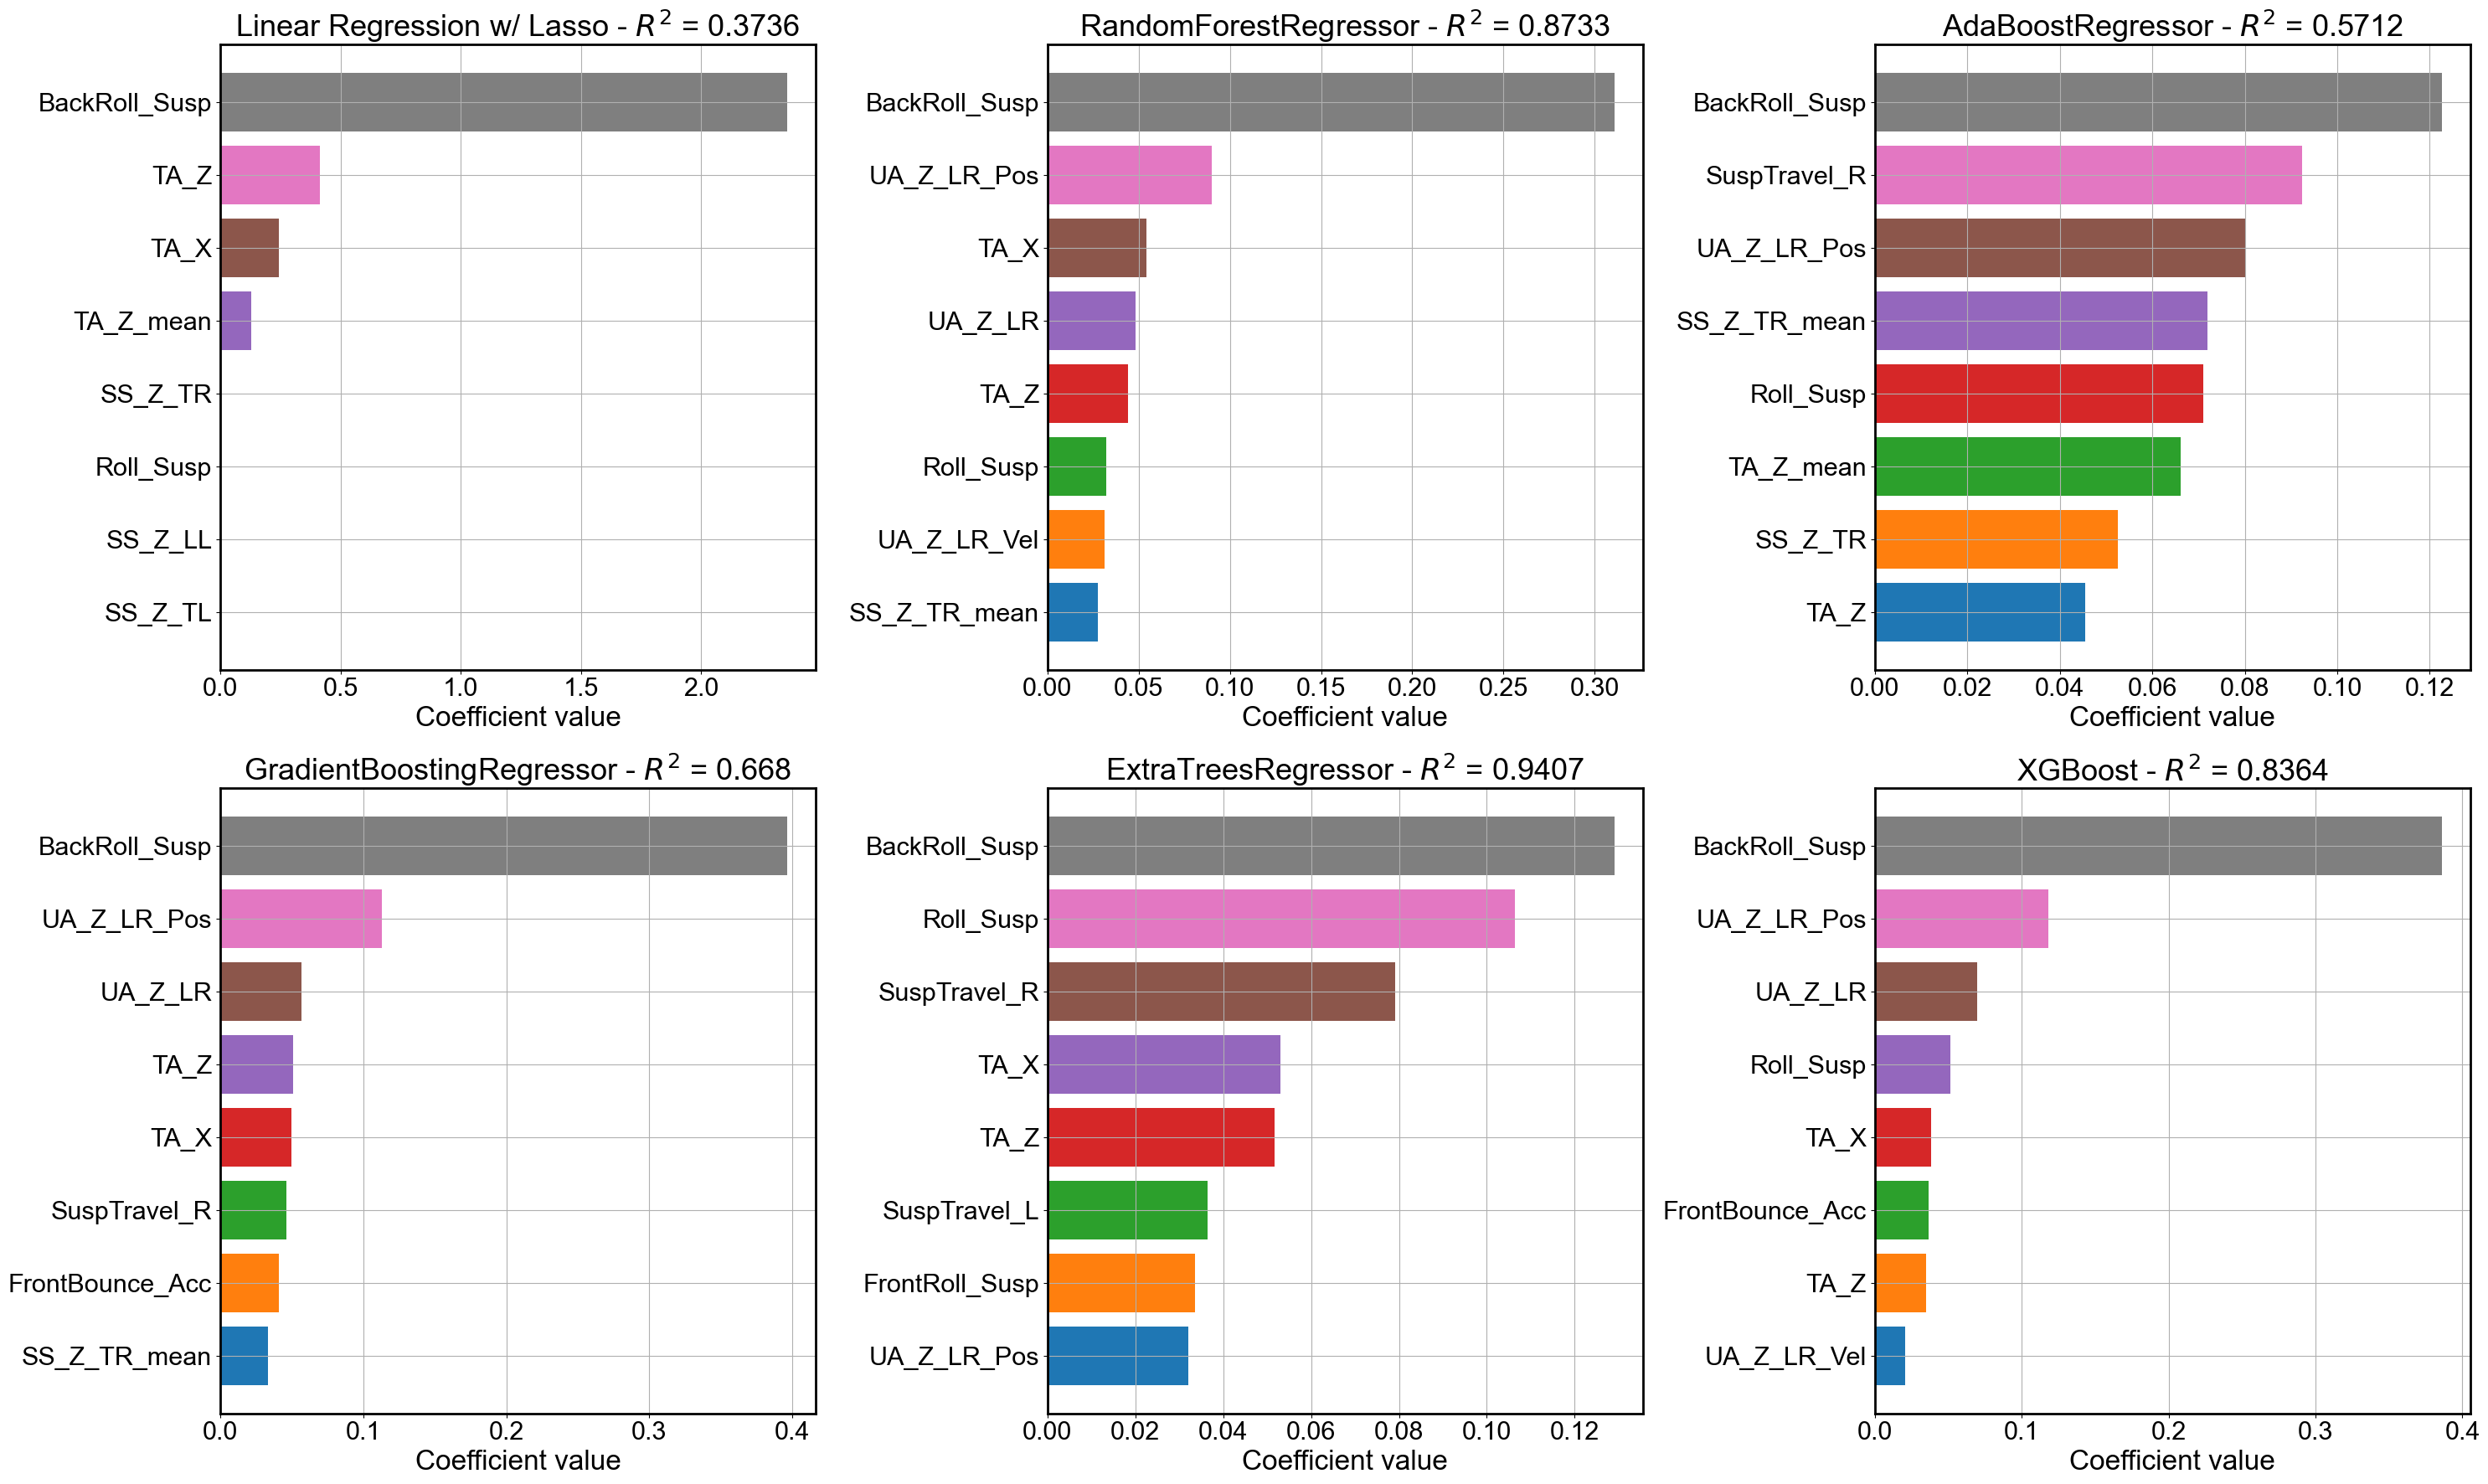

In [34]:
multi_select = multivariate_importance(X_train_2,X_test_2,y_train,y_test)
multi_select.plot(relative=False)

# Polynomial features

In [35]:
# df_aux4 = df_feature_engineered.copy()

# y = df_aux4['Vert_irreg_right_rail']
# X = df_aux4.drop(['Vert_irreg_right_rail'],axis=1)

In [36]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
# X_poly = poly.fit_transform(X)
# X_poly.shape

In [37]:
# X_poly_aux = pd.DataFrame(X_poly, columns=poly.get_feature_names())
# X_poly_aux

In [38]:
# X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X_poly_aux,y)

In [39]:
# rf2 = ExtraTreesRegressor(n_estimators = 30,
#                            n_jobs = 1,
#                            #oob_score = True,
#                            #bootstrap = True,
#                            random_state = 0)

# rf.fit(X_scaled_train, y_train)

# print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(X_scaled_train, y_train), rf.score(X_scaled_test, y_test)))

In [40]:
# selector2 = SelectFromModel(estimator=rf2)
# selector2.fit(X_scaled_train,y_train)

In [41]:
# selected_feat= X_scaled_train.columns[(selector2.get_support())]
# len(selected_feat)

In [42]:
# X_train_2 = X_scaled_train[selected_feat]
# X_test_2 = X_scaled_test[selected_feat]
# X_test_2

In [43]:
# multi_select = multivariate_importance(X_train_2,X_test_2,y_train,y_test)
# multi_select.plot(relative=False)

# Exporting dataset

In [44]:
df_feature_engineered

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew,Irr_Z_RR
54,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000749,-0.001817,0.030900,-0.034100,-0.000459,...,0.008054,0.000065,0.000457,-0.000293,0.004538,-1.143003,0.000911,0.001606,0.941525,-0.0712
55,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000749,-0.001812,0.031600,-0.035600,-0.000542,...,0.008238,0.000068,0.000457,-0.000307,0.003883,-1.156428,0.000941,0.001485,0.893110,-0.0753
56,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000727,-0.001605,0.032000,-0.036700,-0.000613,...,0.008436,0.000071,0.000458,-0.000320,0.003208,-1.139831,0.000970,0.001362,0.843661,-0.0791
57,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000650,-0.000912,0.031400,-0.037000,-0.000654,...,0.008647,0.000075,0.000459,-0.000332,0.002527,-1.100159,0.000993,0.001242,0.787577,-0.0827
58,-0.037300,0.030900,0.025100,-0.0257,-0.000202,-0.000574,-0.000219,0.030900,-0.037300,-0.000695,...,0.008870,0.000079,0.000459,-0.000342,0.001840,-1.048016,0.001013,0.001125,0.728316,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.0503,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285,0.0486
68151,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629,0.0511
68152,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025,0.0535
68153,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.000559,0.001721,-0.216170,-0.114961,-0.003272,...,0.053190,0.002829,0.004170,-0.008807,-0.639543,-0.864403,-0.063821,-0.135586,-0.816822,0.0558


In [45]:
df_feature_engineered.to_csv('Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip',index=False,compression="zip")